<a href="https://colab.research.google.com/github/Fake-Review-Detection-Spiill-AI/scenario-1---single-task/blob/main/draft04_singletask_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/dataset_preprocessing.csv',) #dataset hasil preprocessing
df.head()

,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,lowercase_reviews,...,no_number_reviews,no_atribut_reviews,no_repetition_reviews,no_whitespace_reviews,no_banned_reviews,no_slang_reviews,clean_reviews,tokens_reviews,stopword_reviews,stem_reviews
0,nadiadiani_,3,19-03-2021 6:58,non,neutral,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",Acnes Creamy Wash,282,1,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",...,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dahulu utamakan g...,ketahuilah apa jenis kulitmu dahulu utamakan g...,"['ketahuilah', 'apa', 'jenis', 'kulitmu', 'dah...","['ketahuilah', 'jenis', 'kulitmu', 'utamakan',...",tahu jenis kulit utama produk kandung hydratin...
1,jiminee10,3,31-08-2022 5:02,fake,neutral,Salah satu facial wash dari drugstore yang lay...,Acnes Creamy Wash,167,1,salah satu facial wash dari drugstore yang lay...,...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,"['salah', 'satu', 'facial', 'wash', 'dari', 'd...","['salah', 'facial', 'wash', 'drugstore', 'laya...",salah facial wash drugstore layak coba busa ku...
2,srihastutik1987,3,2024-05-22 22:24,fake,neutral,Efek:memberikan kulit tampak lebih cerah\n Tek...,MS GLOW FACIAL WASH,103,1,efek:memberikan kulit tampak lebih cerah\n tek...,...,efek:memberikan kulit tampak lebih cerah\n tek...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,"['efek', 'memberikan', 'kulit', 'tampak', 'leb...","['efek', 'kulit', 'cerah', 'tekstur', 'lembut'...",efek kulit cerah tekstur lembut nyaman asli ba...
3,Aisyah_18,3,01-11-2021 11:32,fake,neutral,cukup memuaskan dengan harga yang terjangkau ...,Acnes Creamy Wash,104,1,cukup memuaskan dengan harga yang terjangkau ...,...,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,"['cukup', 'memuaskan', 'dengan', 'harga', 'yan...","['memuaskan', 'harga', 'terjangkau', 'kualitas...",muas harga jangkau kualitas lumayan sedia mark...
4,christinjuniarti,3,29-06-2018 1:01,trusted,neutral,Dr segi packaging sih oke2 aja dan bisa liat w...,Lip Cream LA Girl,431,1,dr segi packaging sih oke2 aja dan bisa liat w...,...,dr segi packaging sih oke aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dari segi packaging sih oke saja dan bisa liha...,dari segi packaging sih oke saja dan bisa liha...,"['dari', 'segi', 'packaging', 'sih', 'oke', 's...","['segi', 'packaging', 'oke', 'warna', 'produk'...",segi packaging oke warna produk dalam pas dico...


# Review


## LSTM


In [5]:
max_len = 100  # Max number of words in a sequence
max_features = 20000
# Tokenize the text
df['stem_reviews'] = df['stem_reviews'].astype(str)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['stem_reviews'])
sequences = tokenizer.texts_to_sequences(df['stem_reviews'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len)

# Convert sentiments to numerical labels
review_label_map = {'trusted': 0, 'fake': 1, 'non': 2}
y = df['label'].map(review_label_map).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
60/60 [==============================] - 21s 300ms/step - loss: 0.7641 - accuracy: 0.6349 - val_loss: 0.4773 - val_accuracy: 0.8687
Epoch 2/10
60/60 [==============================] - 17s 284ms/step - loss: 0.2543 - accuracy: 0.9198 - val_loss: 0.1669 - val_accuracy: 0.9438
Epoch 3/10
60/60 [==============================] - 17s 285ms/step - loss: 0.0923 - accuracy: 0.9693 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 4/10
60/60 [==============================] - 19s 319ms/step - loss: 0.0632 - accuracy: 0.9818 - val_loss: 0.1312 - val_accuracy: 0.9563
Epoch 5/10
60/60 [==============================] - 18s 300ms/step - loss: 0.0329 - accuracy: 0.9922 - val_loss: 0.1450 - val_accuracy: 0.9500
Epoch 6/10
60/60 [==============================] - 19s 310ms/step - loss: 0.0270 - accuracy: 0.9911 - val_loss: 0.1712 - val_accuracy: 0.9542
Epoch 7/10
60/60 [==============================] - 19s 316ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.1476 - val_accuracy: 0.9542

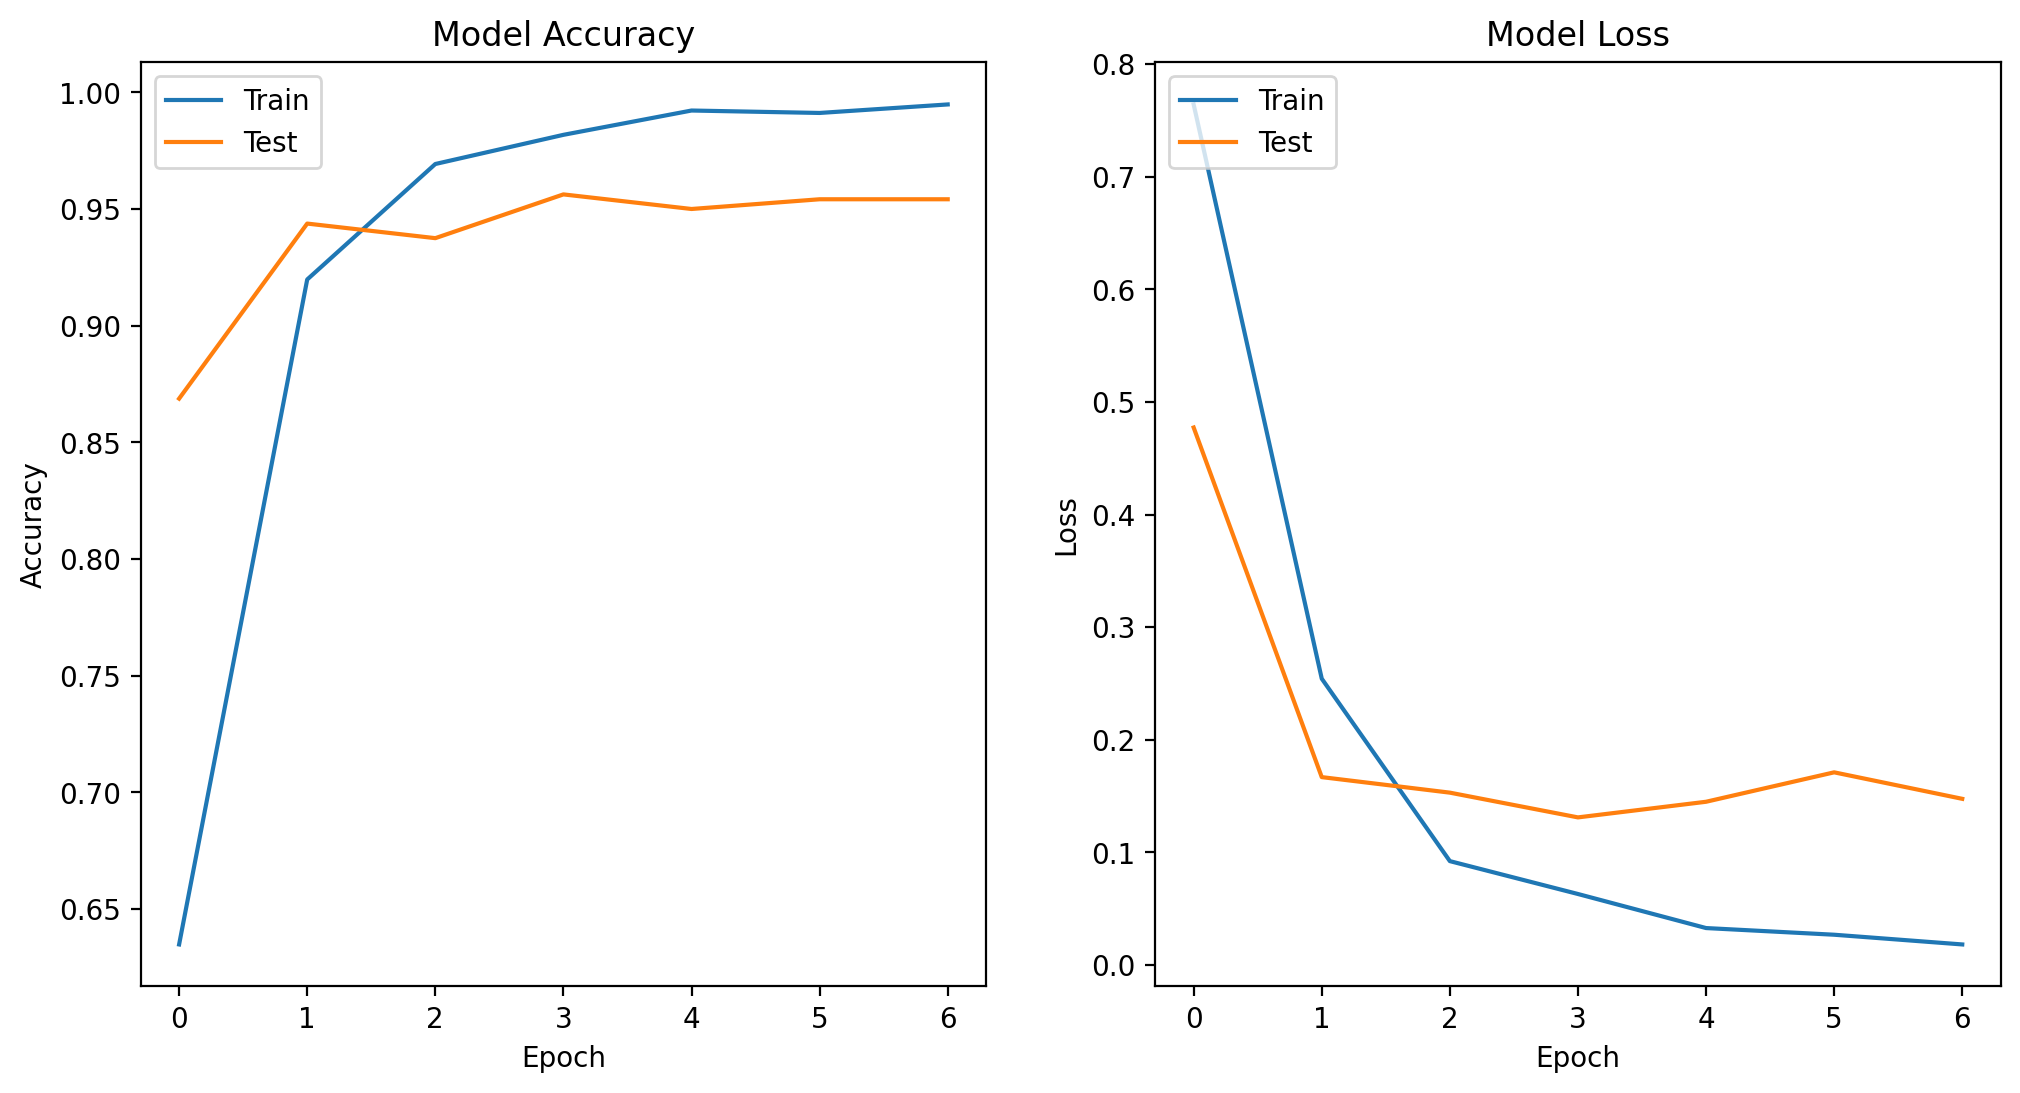

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Test Accuracy: 0.9563
Test Loss: 0.1312
15/15 [==============================] - 1s 37ms/step
Classification Report:
              precision    recall  f1-score   support

     trusted       0.96      1.00      0.98       159
        fake       0.94      0.93      0.94       163
         non       0.97      0.94      0.95       158

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



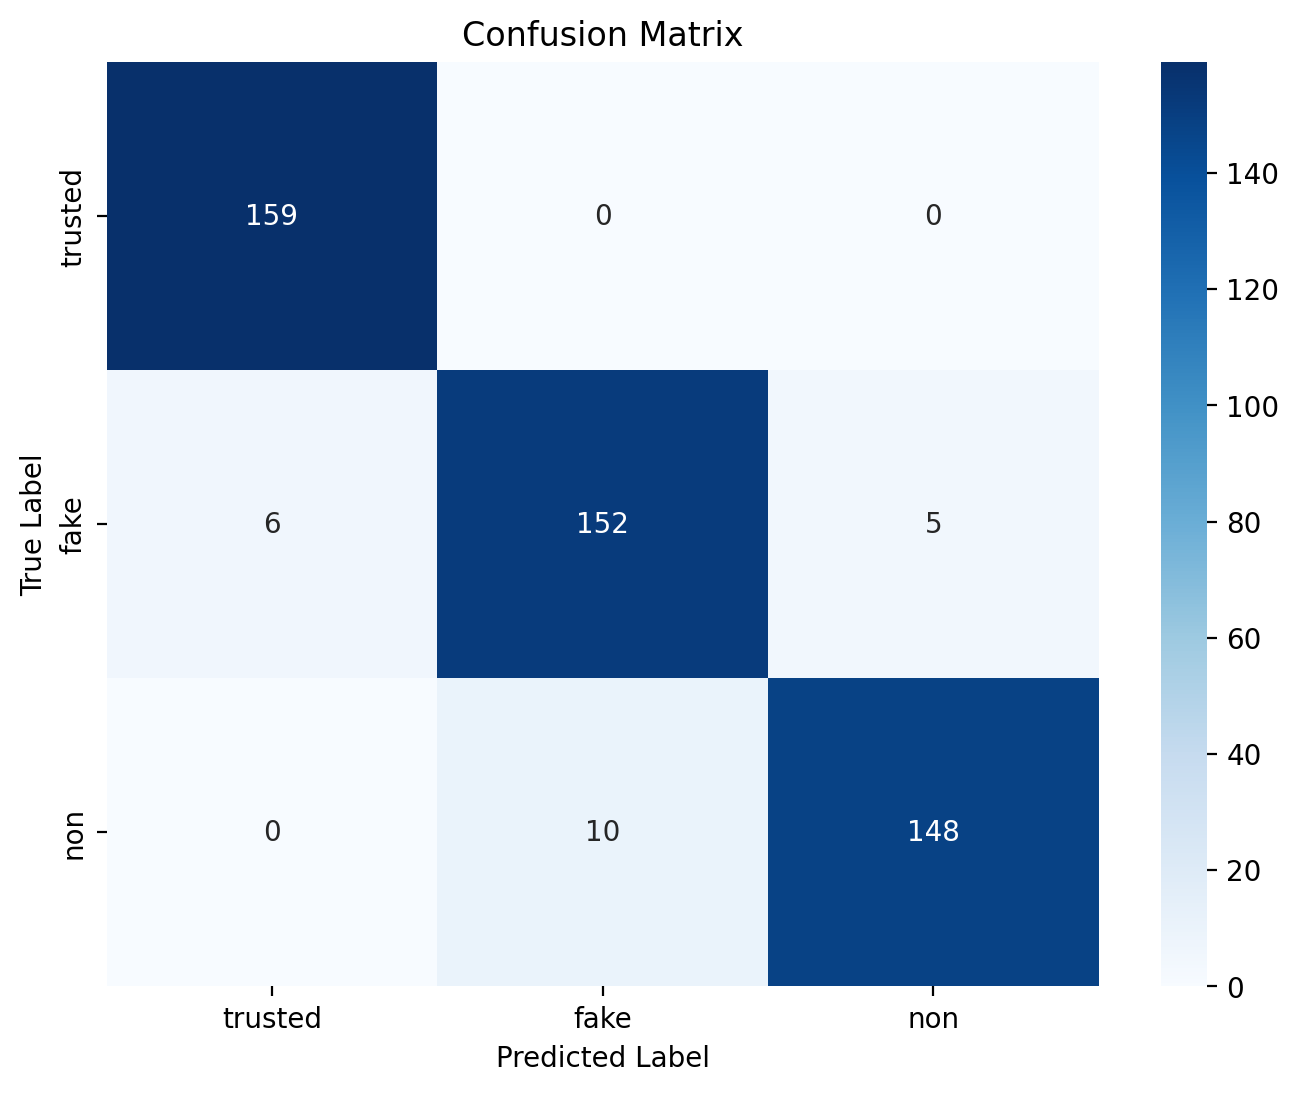

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')

# Predict the labels for the test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['trusted', 'fake', 'non']))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['trusted', 'fake', 'non'], yticklabels=['trusted', 'fake', 'non'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [10]:
from keras.models import load_model

def predict_review(text, model, tokenizer, max_len):
    # Tokenize the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict the sentiment
    prediction = model.predict(padded_sequences)
    predicted_class = prediction.argmax(axis=1)[0]
    confidence = prediction[0][predicted_class] * 100

    # Map the predicted class to the sentiment label
    review_label_map = {0: 'trusted', 1: 'fake', 2: 'non'}
    predicted_label = review_label_map[predicted_class]

    return predicted_label, confidence

# Load the tokenizer and model
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['stem_reviews'])  # Ensure the tokenizer is fitted on the training data
best_model = load_model('best_model.h5')

In [11]:
# Example usage
text = input("Enter the text to analyze review: ")
predicted_label, confidence = predict_review(text, best_model, tokenizer, max_len)

print(f'Text: {text}')
print(f'Predicted review: {predicted_label}')
print(f'Confidence: {confidence:.2f}%')

Enter the text to analyze review: sipp
1/1 [==============================] - 0s 356ms/step
Text: sipp
Predicted review: fake
Confidence: 68.32%
